In [ ]:
!pip install wandb
!pip install kaggle
!pip install retina-face

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

 96% 317M/331M [00:02<00:00, 152MB/s]
100% 331M/331M [00:02<00:00, 164MB/s]


In [4]:
!unzip -qq utkface-new.zip

In [5]:
import torch, torchvision, wandb, os, cv2
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

🔸wandb config

In [6]:
configs = {
            "learning_rate": 0.001,
            "epochs": 20,
            "batch_size": 64,
           }

wandb.init(project="Age-Estimating-by-Torch", config=configs)
config = wandb.config

In [7]:
epochs = 12
width = height = 224

In [8]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [9]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[157, 121, 71], [159, 123, 73], [162, 126, 7...",2
1,"[[[252, 255, 255], [254, 255, 255], [255, 255,...",10
2,"[[[42, 42, 42], [34, 34, 34], [29, 29, 29], [3...",27
3,"[[[120, 115, 121], [103, 98, 104], [106, 101, ...",80
4,"[[[243, 28, 98], [241, 24, 95], [239, 17, 90],...",1


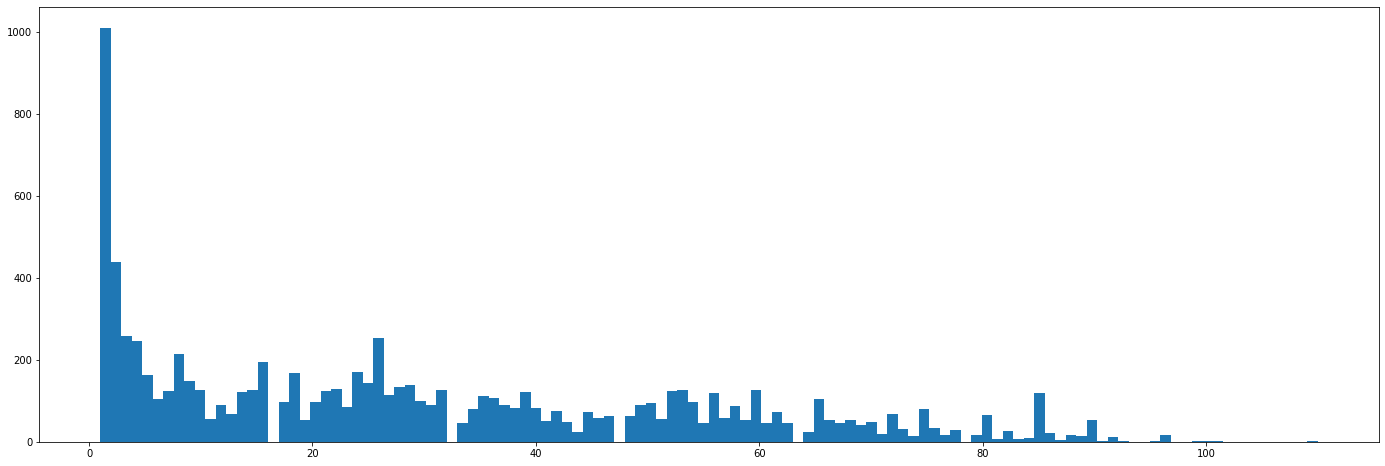

In [10]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 116)
plt.show()

In [11]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

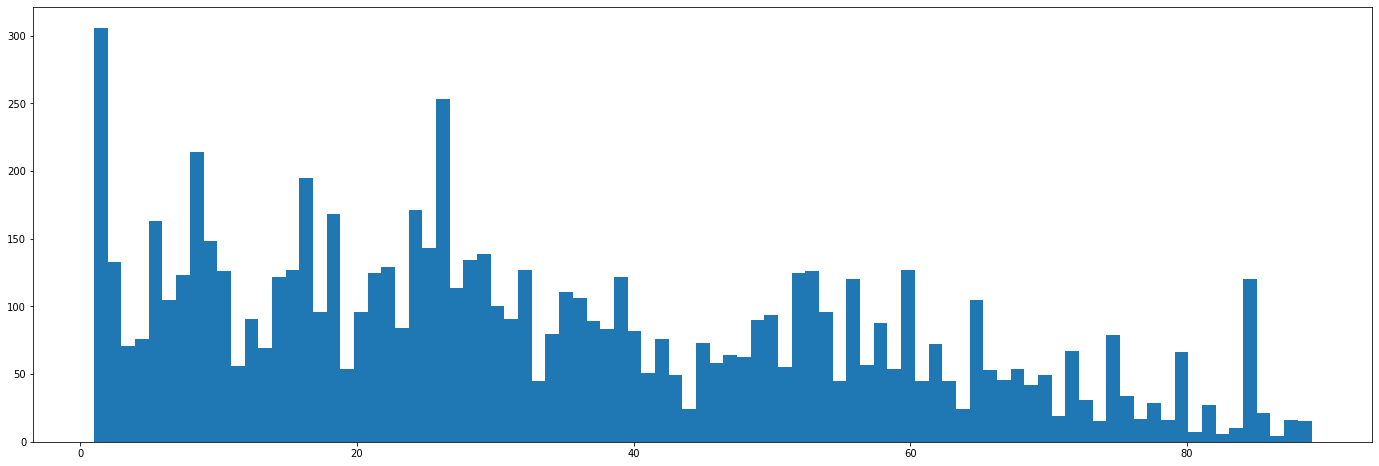

In [12]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [13]:
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


🔸Class

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(32, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))

        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, kernel_size=(2, 2))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, kernel_size=(2, 2))
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, kernel_size=(2, 2))
      x = F.relu(self.conv4(x))
      x = torch.flatten(x, start_dim=1)
      x = F.relu(self.fc1(x))
      x = torch.flatten(x, start_dim=1)
      x = torch.dropout(x, 0.2, train=True)
      x = self.fc2(x)
      x = torch.softmax(x, dim=1)

      return x

In [15]:
device = torch.device("cuda")
model = Model()
model = model.to(device)
model.train(True)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
batch = 64
epoch = 20
lr = 0.001
config.learning_rate = lr

In [17]:
data_transform = transforms.Compose([
                                     transforms.RandomRotation(10),
                                     transforms.Resize((70, 70)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])


X = data_transform(X)

dataset = torch.utils.data.DataLoader((X,Y), batch_size = batch)

TypeError: ignored

In [ ]:
train_data = torch.utils.data.DataLoader(dataset,batch_size=batch,shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
def cal_acc(y_hat,labels):
    _,y_hat_max=torch.max(y_hat,1)
    acc=torch.sum(y_hat_max==labels.data,dtype=torch.float64)/len(y_hat)
    return acc


🔸Train

In [ ]:
for ep in range(epoch):
    train_loss = 0.0
    train_acc = 0.0

    for im,labels in train_data:
        im = im.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #forwarding
        y_hat = model(im)

        #backwarding
        loss = loss_func(y_hat,labels)
        loss.backward()

        #update
        optimizer.step()

        train_loss += loss
        train_acc += cal_acc(y_hat,labels)

    total_loss  =  train_loss/len(train_data)
    total_acc  =  train_acc/len(train_data)

    print(f"epoch:{ep} , Loss:{total_loss} , accuracy: {total_acc}")

    wandb.log({'epochs': ep,
      'train_acc': total_acc,
      'train_loss': total_loss})

🔸Save weights

In [ ]:
torch.save(model.state_dict(), "age-estimating-torch.pth")

In [ ]:
import cv2
import numpy as np

🔸Inference